# [LAB 11] 2. 상관분석 연습문제

#### 패키지 가져오기

In [28]:
from hossam import load_data
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np

import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, pearsonr, spearmanr

#### 그래프 초기화 

In [29]:
#한글을 지원하는 폰트 파일의 경로
font_path ='C:\\Data_Analysis_Basic\\[LAB-06] 데이터 시각화 개요\\NotoSansKR-Regular.ttf'
#폰트의 그룹을 시스템에 등록
fm.fontManager.addfont(font_path)
#폰트의 속성을 읽어옴
font_prop = fm.FontProperties(fname=font_path)
#읽어온 속성에서 폰트의 이름만 추출
font_name = font_prop.get_name()

#이미지의 선명도를 결정 (1인치 당 픽셀의 수)
my_dpi = 120 
#시스템에 등록된 글꼴 이름  (상단에서 확인한 폰트 이름으로 넣기)
my_font_name = 'Noto Sans KR'
#그림 스타일 지정
my_theme = 'dark'
#seaborn 스타일 (화풍 설정하기)
sb.set_theme(style=my_theme)
#그래프에 한글 폰트 적용
plt.rcParams['font.family']=my_font_name
#기본 폰트 크기
plt.rcParams['font.size'] =16
#그래프에 마이너스 꺠짐 방지 (한글환경에서 필수)
plt.rcParams['axes.unicode_minus']=False

### 문제 1 
baseball 데이터셋은 야구팀의 홈런수와 타율에 관한 자료이다. 홈런수와 평균타율이 상관관계
가 있는지 그 관련성을 분석하라.

In [30]:
baseball = load_data('baseball')
print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기: {baseball.shape}")
print(f"열 개수: {baseball.shape[1]}")
print(f"행 개수: {baseball.shape[0]}")
print("\n===== 타입확인 =====")
print(baseball.info())
baseball.head()

[data] https://data.hossam.kr/data/lab11_/baseball.xlsx
[desc] 야구팀의 홈런수와 타율에 관한 자료 (출처: 방송통신대학교 통계학 개론)
[!] Cannot read metadata

===== 데이터 크기 확인 =====
데이터셋 크기: (14, 2)
열 개수: 2
행 개수: 14

===== 타입확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   홈런수     14 non-null     int64  
 1   평균타율    14 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 356.0 bytes
None


,홈런수,평균타율
0,174,0.277
1,163,0.276
2,161,0.272
3,230,0.272
4,214,0.269


<산점도 그래프>

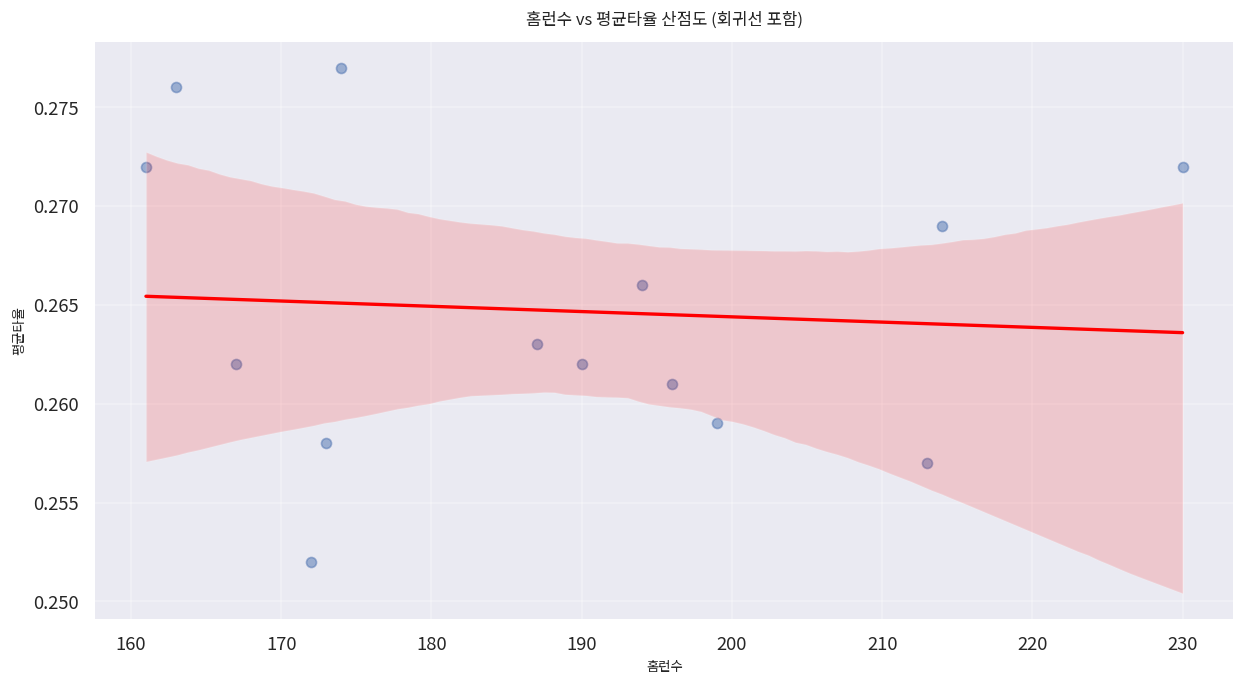

In [31]:
# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 1280              # 그래프 가로 크기
height_px = 720              # 그래프 세로 크기
rows = 1                     # 그래프 행 수
cols = 1                     # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) Scatter Plor 그리기
sb.regplot(data=baseball , x = '홈런수' , y='평균타율' , scatter_kws = {'alpha':0.5}, line_kws ={'color':'red' , 'linewidth' : 2})

# 3) 그래프 꾸미기
ax.set_title('홈런수 vs 평균타율 산점도 (회귀선 포함)', fontsize=10, pad=10)
ax.set_xlabel('홈런수', fontsize=8)
ax.set_ylabel('평균타율', fontsize=8)
ax.grid(True, alpha=0.3)           
# 배경 격자 표시

# 4) 출력
plt.tight_layout()                     # 여백 제거
plt.show()                             # 그래프 화면 출력
plt.close()                            # 그래프 작업 종료


<선형성 통계적 검정 - Ramsey RESET TEST>

In [32]:
x = baseball ['홈런수']
y = baseball ['평균타율']

X = sm.add_constant(x)
model=sm.OLS(y,X).fit()
reset = linear_reset(model,power=2,use_f = True)


#선형성 적합 여부 (True=적합, False=부적합)
linearity_ok = reset.pvalue > 0.05
print(f"Ramsey RESET Test : {'선형성 적합' if linearity_ok else '선형성 위반'} (p-value: {reset.pvalue:.4f})")


Ramsey RESET Test : 선형성 적합 (p-value: 0.0910)


<분포 왜도를 통한 이상치 점검>

In [33]:
# 이상치와 왜도 검정
data = baseball[['홈런수', '평균타율']]
results = {}

for col in data.columns:
    temp = data[col].dropna()

    # 왜도 계산
    skew_original = temp.skew()

    # Z-score 기반 이상치 탐지 (|z| > 3)
    z_scores = zscore(temp)
    outlier_count = int(np.sum(np.abs(z_scores) > 3))

    # 로그 변환 후 왜도 계산 (음수 대비 +1)
    data_log = np.log1p(temp - temp.min() + 1)
    skew_log = data_log.skew()

    # 로그 변환 필요 여부 판단
    need_log = (abs(skew_original) > 1) and (abs(skew_log) < abs(skew_original))

    results[col] = {
        'original_skew': skew_original,
        'log_skew': skew_log,
        'outliers(|z|>3)': outlier_count,
        'log_recommended': need_log,
    }

# 결과 dataframe 변환
results_df = pd.DataFrame(results).T
display(results_df)

# 이상치 검정 결과
outlier_flag = len(results_df[results_df['outliers(|z|>3)'] > 0]) > 0


if outlier_flag:
    print("이상치가 발견되어 스피어만 상관계수 사용")
else:
    print("이상치가 발견되지 않아 피어슨 상관계수 사용")


,original_skew,log_skew,outliers(|z|>3),log_recommended
홈런수,0.512832,-0.97408,0,False
평균타율,0.220918,0.214929,0,False


이상치가 발견되지 않아 피어슨 상관계수 사용


<상관분석>

In [34]:
pearson_r, pearson_p = pearsonr(baseball['홈런수'], baseball['평균타율'])
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(pearson_r, pearson_p,  "대립" if pearson_p <= 0.05 else "귀무")

'statistic: -0.075, p-value: 0.800, 귀무가설 채택'

In [35]:
spearman_r, spearman_p = spearmanr(baseball['홈런수'], baseball['평균타율'])
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(spearman_r, spearman_p,  "대립" if spearman_p <=
0.05 else "귀무")

'statistic: -0.130, p-value: 0.658, 귀무가설 채택'

In [36]:
# 1. 상관계수 선택
if linearity_ok and not outlier_flag:
    chosen = 'pearson'
    corr, pval = pearson_r, pearson_p
    rationale = '선형성 만족 + 왜도/이상치 영향 작음으로 판단'
else:
    chosen = 'spearman'
    corr, pval = spearman_r, spearman_p
    rationale = '비선형(또는 이상치 영향) 가능성 고려'

print('=' * 50)
print('📊 상관계수 요약')
print('=' * 50)

print(f"Pearson r: {pearson_r:.3f}, p-value: {pearson_p:.4f}")
print(f"Spearman rho: {spearman_r:.3f}, p-value: {spearman_p:.4f}")

print('\n' + '=' * 50)
print('✅ 최종 선택 결과')
print('=' * 50)

print(f"✔ 선택된 방법: {chosen}")
print(f"✔ 상관계수: {corr:.3f}")
print(f"✔ p-value: {pval:.4f}")
print(f"✔ 선택 근거: {rationale}")

print('=' * 50)


📊 상관계수 요약
Pearson r: -0.075, p-value: 0.7997
Spearman rho: -0.130, p-value: 0.6579

✅ 최종 선택 결과
✔ 선택된 방법: pearson
✔ 상관계수: -0.075
✔ p-value: 0.7997
✔ 선택 근거: 선형성 만족 + 왜도/이상치 영향 작음으로 판단


본 분석에서는 {홈런수}과 {평균타율} 간 상관관계를 검토하였다.

데이터 점검 결과, 두 변수의 관계는 선형적이며, 이상치의 영향도 크지 않아 피어슨 상관계수를 사용하였다

분석 결과, 피어슨 상관계수는 rho = -0.075, p = 0.7997 로 나타나 두 변수 간 음의 단조 관계가 관계가 통계적으로 유의하지 않음을 확인하였다.

### 문제 2 

product 데이터셋은 어떤 원료의 품질특성(x)과 이 원료를 사용하여 만든 제품의 특성(y)에 관
한 조사를 한 결과 이다.


이들 간 상관관계를 구하고 상관 유무 검정을 유의수준 5%에서 실시하라.


<데이터 가져오기>

In [37]:
product = load_data('product')
print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기: {product.shape}")
print(f"열 개수: {product.shape[1]}")
print(f"행 개수: {product.shape[0]}")
print("\n===== 타입확인 =====")
print(product.info())
product.head()

[data] https://data.hossam.kr/data/lab11_/product.xlsx
[desc] 어떤 원료의 품질특성(x)과 이 원료를 사용하여 만든 제품의 특성(y)에 관한 조사결과 (출처: 방송통신대학교 통계학 개론)
[!] Cannot read metadata

===== 데이터 크기 확인 =====
데이터셋 크기: (10, 2)
열 개수: 2
행 개수: 10

===== 타입확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   x       10 non-null     int64
 1   y       10 non-null     int64
dtypes: int64(2)
memory usage: 292.0 bytes
None


,x,y
0,36,29
1,40,32
2,34,29
3,44,40
4,33,31


<산점도 확인>

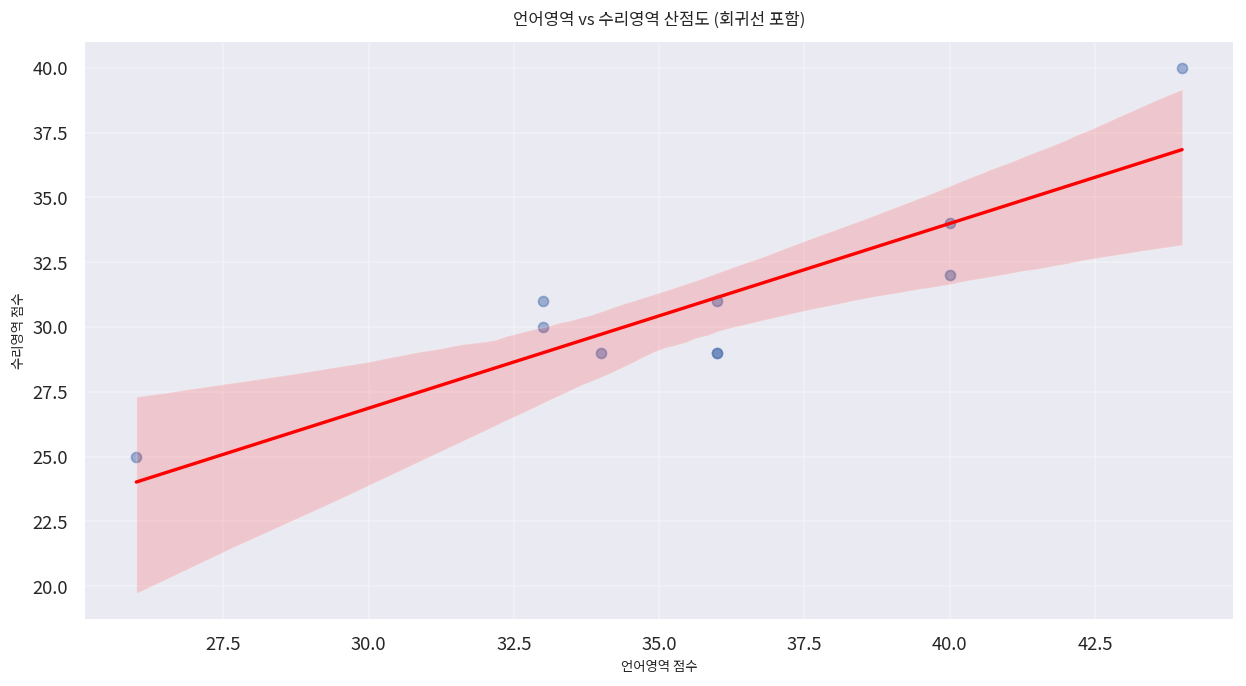

In [38]:
# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 1280              # 그래프 가로 크기
height_px = 720              # 그래프 세로 크기
rows = 1                     # 그래프 행 수
cols = 1                     # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) Scatter Plor 그리기
sb.regplot(data=product , x = 'x' , y='y' , scatter_kws = {'alpha':0.5}, line_kws ={'color':'red' , 'linewidth' : 2})

# 3) 그래프 꾸미기
ax.set_title('언어영역 vs 수리영역 산점도 (회귀선 포함)', fontsize=10, pad=10)
ax.set_xlabel('언어영역 점수', fontsize=8)
ax.set_ylabel('수리영역 점수', fontsize=8)
ax.grid(True, alpha=0.3)           
# 배경 격자 표시

# 4) 출력
plt.tight_layout()                     # 여백 제거
plt.show()                             # 그래프 화면 출력
plt.close()                            # 그래프 작업 종료


<선형성 통계적 검정>

In [39]:
x = product ['x']
y = product ['y']

X = sm.add_constant(x)
model=sm.OLS(y,X).fit()
reset = linear_reset(model,power=2,use_f = True)


#선형성 적합 여부 (True=적합, False=부적합)
linearity_ok = reset.pvalue > 0.05
print(f"Ramsey RESET Test : {'선형성 적합' if linearity_ok else '선형성 위반'} (p-value: {reset.pvalue:.4f})")


Ramsey RESET Test : 선형성 적합 (p-value: 0.1206)


<이상치와 왜도 검정>

In [40]:
# 이상치와 왜도 검정
data = product[['x', 'y']]
results = {}

for col in data.columns:
    temp = data[col].dropna()

    # 왜도 계산
    skew_original = temp.skew()

    # Z-score 기반 이상치 탐지 (|z| > 3)
    z_scores = zscore(temp)
    outlier_count = int(np.sum(np.abs(z_scores) > 3))

    # 로그 변환 후 왜도 계산 (음수 대비 +1)
    data_log = np.log1p(temp - temp.min() + 1)
    skew_log = data_log.skew()

    # 로그 변환 필요 여부 판단
    need_log = (abs(skew_original) > 1) and (abs(skew_log) < abs(skew_original))

    results[col] = {
        'original_skew': skew_original,
        'log_skew': skew_log,
        'outliers(|z|>3)': outlier_count,
        'log_recommended': need_log,
    }

# 결과 dataframe 변환
results_df = pd.DataFrame(results).T
display(results_df)

# 이상치 검정 결과
outlier_flag = len(results_df[results_df['outliers(|z|>3)'] > 0]) > 0



if outlier_flag:
    print("이상치가 발견되어 스피어만 상관계수 사용")
else:
    print("이상치가 발견되지 않아 피어슨 상관계수 사용")


,original_skew,log_skew,outliers(|z|>3),log_recommended
x,-0.340387,-2.178627,0,False
y,1.168124,-1.066498,0,True


이상치가 발견되지 않아 피어슨 상관계수 사용


<상관분석>

In [41]:
pearson_r, pearson_p = pearsonr(product['x'], product['y'])
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(pearson_r, pearson_p,  "대립" if pearson_p <= 0.05 else "귀무")

'statistic: 0.888, p-value: 0.001, 대립가설 채택'

In [42]:
spearman_r, spearman_p = spearmanr(product['x'], product['y'])
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(spearman_r, spearman_p,  "대립" if spearman_p <=
0.05 else "귀무")

'statistic: 0.737, p-value: 0.015, 대립가설 채택'

<상관계수 선택>

In [43]:
# 1. 상관계수 선택
if linearity_ok and not outlier_flag:
    chosen = 'pearson'
    corr, pval = pearson_r, pearson_p
    rationale = '선형성 만족 + 왜도/이상치 영향 작음으로 판단'
else:
    chosen = 'spearman'
    corr, pval = spearman_r, spearman_p
    rationale = '비선형(또는 이상치 영향) 가능성 고려'

print('=' * 50)
print('📊 상관계수 요약')
print('=' * 50)

print(f"Pearson r: {pearson_r:.3f}, p-value: {pearson_p:.4f}")
print(f"Spearman rho: {spearman_r:.3f}, p-value: {spearman_p:.4f}")

print('\n' + '=' * 50)
print('✅ 최종 선택 결과')
print('=' * 50)

print(f"✔ 선택된 방법: {chosen}")
print(f"✔ 상관계수: {corr:.3f}")
print(f"✔ p-value: {pval:.4f}")
print(f"✔ 선택 근거: {rationale}")

print('=' * 50)


📊 상관계수 요약
Pearson r: 0.888, p-value: 0.0006
Spearman rho: 0.737, p-value: 0.0151

✅ 최종 선택 결과
✔ 선택된 방법: pearson
✔ 상관계수: 0.888
✔ p-value: 0.0006
✔ 선택 근거: 선형성 만족 + 왜도/이상치 영향 작음으로 판단


본 분석에서는 {x}과 {y} 간 상관관계를 검토하였다.

데이터 점검 결과, 두 변수의 관계는 선형적이며 이상치는 확인되지 않아 피어슨 상관계수를 사용하였다.

분석 결과, 스피어만 상관계수는 r = {0.888}, p = {0.0006}로 나타나 두 변수 간 {양의 단조 관계} 관계가 통계적으로 유의함을 확인하였다.

### 문제 3
study_time 은 학생들에 대한 공부 시간과 성적 데이터이다. 분석하라

<데이터 가져오기>

In [44]:
study_time = load_data('study_time')
print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기: {study_time.shape}")
print(f"열 개수: {study_time.shape[1]}")
print(f"행 개수: {study_time.shape[0]}")
print("\n===== 타입확인 =====")
print(study_time.info())
study_time.head()

[data] https://data.hossam.kr/data/lab11_/study_time.xlsx
[desc] 학생들에 대한 공부 시간과 성적 데이터 (출처: 방송통신대학교 통계학 개론)
[!] Cannot read metadata

===== 데이터 크기 확인 =====
데이터셋 크기: (10, 2)
열 개수: 2
행 개수: 10

===== 타입확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   공부시간    10 non-null     int64
 1   성적      10 non-null     int64
dtypes: int64(2)
memory usage: 292.0 bytes
None


,공부시간,성적
0,2,65
1,4,85
2,3,75
3,5,90
4,6,95


<산점도 그래프 그리기>

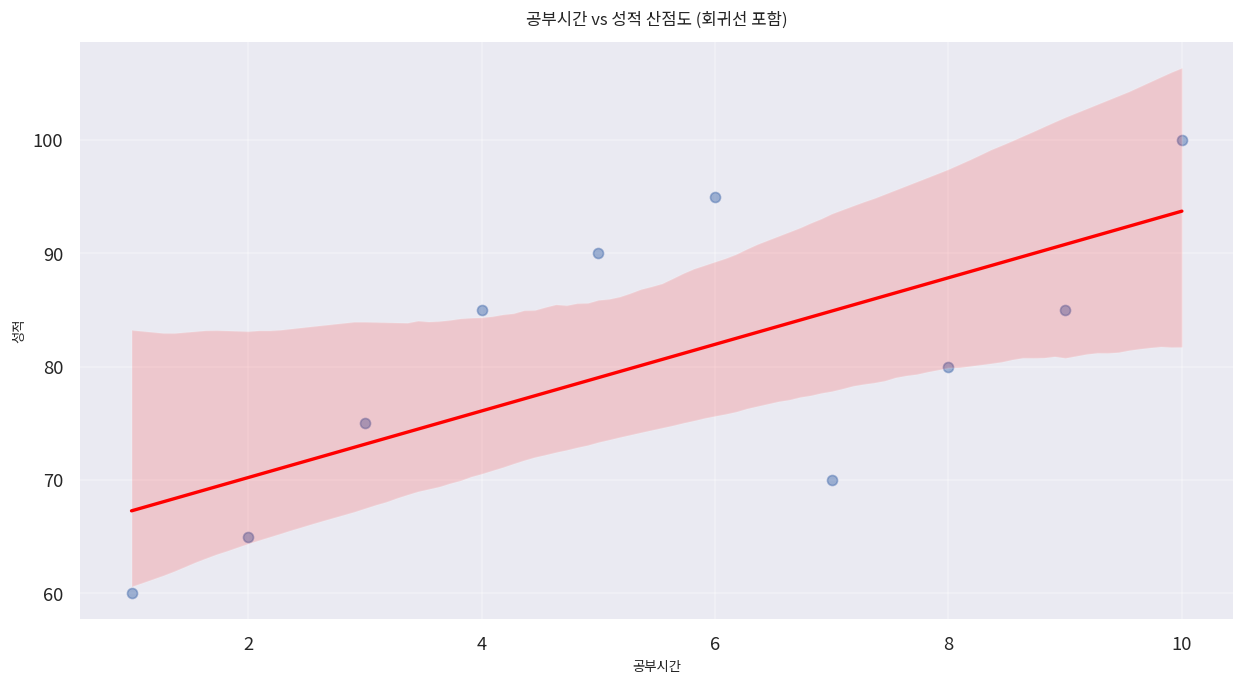

In [45]:
# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 1280              # 그래프 가로 크기
height_px = 720              # 그래프 세로 크기
rows = 1                     # 그래프 행 수
cols = 1                     # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) Scatter Plor 그리기
sb.regplot(data=study_time , x = '공부시간' , y='성적' , scatter_kws = {'alpha':0.5}, line_kws ={'color':'red' , 'linewidth' : 2})

# 3) 그래프 꾸미기
ax.set_title('공부시간 vs 성적 산점도 (회귀선 포함)', fontsize=10, pad=10)
ax.set_xlabel('공부시간', fontsize=8)
ax.set_ylabel('성적', fontsize=8)
ax.grid(True, alpha=0.3)           
# 배경 격자 표시

# 4) 출력
plt.tight_layout()                     # 여백 제거
plt.show()                             # 그래프 화면 출력
plt.close()                            # 그래프 작업 종료


<선형성 통계적 검정>

In [46]:
x = study_time ['공부시간']
y = study_time ['성적']

X = sm.add_constant(x)
model=sm.OLS(y,X).fit()
reset = linear_reset(model,power=2,use_f = True)


#선형성 적합 여부 (True=적합, False=부적합)
linearity_ok = reset.pvalue > 0.05
print(f"Ramsey RESET Test : {'선형성 적합' if linearity_ok else '선형성 위반'} (p-value: {reset.pvalue:.4f})")


Ramsey RESET Test : 선형성 적합 (p-value: 0.4234)


<분포 왜도를 통한 이상치 점검>

In [47]:
# 이상치와 왜도 검정
data = study_time[['공부시간', '성적']]
results = {}

for col in data.columns:
    temp = data[col].dropna()

    # 왜도 계산
    skew_original = temp.skew()

    # Z-score 기반 이상치 탐지 (|z| > 3)
    z_scores = zscore(temp)
    outlier_count = int(np.sum(np.abs(z_scores) > 3))

    # 로그 변환 후 왜도 계산 (음수 대비 +1)
    data_log = np.log1p(temp - temp.min() + 1)
    skew_log = data_log.skew()

    # 로그 변환 필요 여부 판단
    need_log = (abs(skew_original) > 1) and (abs(skew_log) < abs(skew_original))

    results[col] = {
        'original_skew': skew_original,
        'log_skew': skew_log,
        'outliers(|z|>3)': outlier_count,
        'log_recommended': need_log,
    }

# 결과 dataframe 변환
results_df = pd.DataFrame(results).T
display(results_df)

# 이상치 검정 결과
outlier_flag = len(results_df[results_df['outliers(|z|>3)'] > 0]) > 0


if outlier_flag:
    print("이상치가 발견되어 스피어만 상관계수 사용")
else:
    print("이상치가 발견되지 않아 피어슨 상관계수 사용")


,original_skew,log_skew,outliers(|z|>3),log_recommended
공부시간,0.0,-0.762678,0,False
성적,-0.136348,-1.573659,0,False


이상치가 발견되지 않아 피어슨 상관계수 사용


<스피어만 상관계수>

In [48]:
spearman_r, spearman_p = spearmanr(study_time['공부시간'], study_time['성적'])
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(spearman_r, spearman_p,  "대립" if spearman_p <=
0.05 else "귀무")

'statistic: 0.657, p-value: 0.039, 대립가설 채택'

<가정에 따른 상관계수 선택>

In [49]:
# 1. 상관계수 선택
if linearity_ok and not outlier_flag:
    chosen = 'pearson'
    corr, pval = pearson_r, pearson_p
    rationale = '선형성 만족 + 왜도/이상치 영향 작음으로 판단'
else:
    chosen = 'spearman'
    corr, pval = spearman_r, spearman_p
    rationale = '비선형(또는 이상치 영향) 가능성 고려'

print('=' * 50)
print('📊 상관계수 요약')
print('=' * 50)

print(f"Pearson r: {pearson_r:.3f}, p-value: {pearson_p:.4f}")
print(f"Spearman rho: {spearman_r:.3f}, p-value: {spearman_p:.4f}")

print('\n' + '=' * 50)
print('✅ 최종 선택 결과')
print('=' * 50)

print(f"✔ 선택된 방법: {chosen}")
print(f"✔ 상관계수: {corr:.3f}")
print(f"✔ p-value: {pval:.4f}")
print(f"✔ 선택 근거: {rationale}")

print('=' * 50)


📊 상관계수 요약
Pearson r: 0.888, p-value: 0.0006
Spearman rho: 0.657, p-value: 0.0392

✅ 최종 선택 결과
✔ 선택된 방법: pearson
✔ 상관계수: 0.888
✔ p-value: 0.0006
✔ 선택 근거: 선형성 만족 + 왜도/이상치 영향 작음으로 판단


본 분석에서는 {공부시간}과 {성적} 간 상관관계를 검토하였다.

데이터 점검 결과, 두 변수의 관계는 선형적이며 이상치의 영향이 있어 스피어만 상관계수를 사용하였다.

분석 결과, 스피어만 상관계수는 r = {0.888}, p = {0.0006}로 나타나 두 변수 간 {양의 단조} 관계가 통계적으로 유의함을 확인하였다.
